# Deep Learning with Google Earth Engine, Cloud Storage and AI Platform

This notebook is inspired by the following tutorials:

- [Getting started: Training and prediction with Keras](https://cloud.google.com/ml-engine/docs/tensorflow/getting-started-keras)
- [Down to Earth with AI Platform](https://medium.com/google-earth/down-to-earth-with-ai-platform-7bc363abf4fa)
- [Deploying to AI Platform](https://developers.google.com/earth-engine/tf_examples#deploying-to-ai-platform)

## Setup software libraries

In [1]:
# Import and initialize the Earth Engine library.
import ee
ee.Initialize()
ee.__version__

'0.1.202'

In [2]:
# Folium setup.
import folium
print(folium.__version__)

0.8.3


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import functools
import json
from pprint import pprint
import env

## Earth Engine ImageCollection attributes

We define the different attributes that we will need for each Earth Engine ImageCollection all through the notebook. 

We include them in the `ee_collection_specifics.py` file:

In [4]:
%%writefile ee_collection_specifics.py

"""
Information on Earth Engine collections stored here (e.g. bands, collection ids, etc.)
"""

import ee

def ee_collections(collection):
    """
    Earth Engine image collection names
    """
    dic = {
        'Sentinel2_TOA': 'COPERNICUS/S2',
        'Landsat7_SR': 'LANDSAT/LE07/C01/T1_SR',
        'Landsat8_SR': 'LANDSAT/LC08/C01/T1_SR',
        'CroplandDataLayers': 'USDA/NASS/CDL',
        'NationalLandCoverDatabase': 'USGS/NLCD'
    }
    
    return dic[collection]

def ee_bands(collection):
    """
    Earth Engine band names
    """
    
    dic = {
        'Sentinel2_TOA': ['B1','B2','B3','B4','B5','B6','B7','B8A','B8','B11','B12'],
        'Landsat7_SR': ['B1','B2','B3','B4','B5','B6','B7'],
        'Landsat8_SR': ['B1','B2','B3','B4','B5','B6','B7','B10','B11'],
        'CroplandDataLayers': ['landcover', 'cropland', 'land', 'water', 'urban'],
        'NationalLandCoverDatabase': ['impervious']
    }
    
    return dic[collection]

def ee_bands_rgb(collection):
    """
    Earth Engine rgb band names
    """
    
    dic = {
        'Sentinel2_TOA': ['B4','B3','B2'],
        'Landsat7_SR': ['B3','B2','B1'],
        'Landsat8_SR': ['B4', 'B3', 'B2'],
        'CroplandDataLayers': ['landcover'],
        'NationalLandCoverDatabase': ['impervious']
    }
    
    return dic[collection]

def ee_bands_normThreshold(collection):
    """
    Normalization threshold percentage
    """
    
    dic = {
        'Sentinel2_TOA': {'B1': 75,'B2': 75,'B3': 75,'B4': 75,'B5': 80,'B6': 80,'B7': 80,'B8A': 80,'B8': 80,'B11': 100,'B12': 100},
        'Landsat7_SR': {'B1': 95,'B2': 95,'B3': 95,'B4': 100,'B5': 100,'B6': 100,'B7': 100},
        'Landsat8_SR': {'B1': 90,'B2': 95,'B3': 95,'B4': 95,'B5': 100,'B6': 100,'B7': 100,'B10': 100,'B11': 100},
        'CroplandDataLayers': {'landcover': 100, 'cropland': 100, 'land': 100, 'water': 100, 'urban': 100},
        'NationalLandCoverDatabase': {'impervious': 100}
    }
    
    return dic[collection]

def normalize(collection):
    dic = {
        'Sentinel2_TOA': True,
        'Landsat7_SR': True,
        'Landsat8_SR': True,
        'CroplandDataLayers': False,
        'NationalLandCoverDatabase': False
    }
    
    return dic[collection]

def vizz_params_rgb(collection):
    """
    Visualization parameters
    """
    dic = {
        'Sentinel2_TOA': {'min':0,'max':3000, 'bands':['B4','B3','B2']},
        'Landsat7_SR': {'min':0,'max':3000, 'gamma':1.4, 'bands':['B3','B2','B1']},
        'Landsat8_SR': {'min':0,'max':3000, 'gamma':1.4, 'bands':['B4','B3','B2']},
        'CroplandDataLayers': {'min':0,'max':3, 'bands':['landcover']},
        'NationalLandCoverDatabase': {'min': 0, 'max': 1, 'bands':['impervious']}
    }
    
    return dic[collection]

def vizz_params(collection):
    """
    Visualization parameters
    """
    dic = {
        'Sentinel2_TOA': [{'min':0,'max':1, 'bands':['B4','B3','B2']}, 
                      {'min':0,'max':1, 'bands':['B1']},
                      {'min':0,'max':1, 'bands':['B5']},
                      {'min':0,'max':1, 'bands':['B6']},
                      {'min':0,'max':1, 'bands':['B7']},
                      {'min':0,'max':1, 'bands':['B8A']},
                      {'min':0,'max':1, 'bands':['B8']},
                      {'min':0,'max':1, 'bands':['B11']},
                      {'min':0,'max':1, 'bands':['B12']}],
        'Landsat7_SR': [{'min':0,'max':1, 'gamma':1.4, 'bands':['B3','B2','B1']}, 
                     {'min':0,'max':1, 'gamma':1.4, 'bands':['B4']},
                     {'min':0,'max':1, 'gamma':1.4, 'bands':['B5']},
                     {'min':0,'max':1, 'gamma':1.4, 'bands':['B7']},
                     {'min':0,'max':1, 'gamma':1.4, 'bands':['B6']}],
        'Landsat8_SR': [{'min':0,'max':1, 'gamma':1.4, 'bands':['B4','B3','B2']}, 
                     {'min':0,'max':1, 'gamma':1.4, 'bands':['B1']},
                     {'min':0,'max':1, 'gamma':1.4, 'bands':['B5']},
                     {'min':0,'max':1, 'gamma':1.4, 'bands':['B6']},
                     {'min':0,'max':1, 'gamma':1.4, 'bands':['B7']},
                     {'min':0,'max':1, 'gamma':1.4, 'bands':['B10']},
                     {'min':0,'max':1, 'gamma':1.4, 'bands':['B11']}],
        'CroplandDataLayers': [{'min':0,'max':3, 'bands':['landcover']},
                               {'min':0,'max':1, 'bands':['cropland']},
                               {'min':0,'max':1, 'bands':['land']},
                               {'min':0,'max':1, 'bands':['water']},
                               {'min':0,'max':1, 'bands':['urban']}],
        'NationalLandCoverDatabase': [{'min': 0, 'max': 1, 'bands':['impervious']}]
    }
    
    return dic[collection]

## ------------------------- Filter datasets ------------------------- ##
## Lansat 7 Cloud Free Composite
def CloudMaskL7sr(image):
    qa = image.select('pixel_qa')
    #If the cloud bit (5) is set and the cloud confidence (7) is high
    #or the cloud shadow bit is set (3), then it's a bad pixel.
    cloud = qa.bitwiseAnd(1 << 5).And(qa.bitwiseAnd(1 << 7)).Or(qa.bitwiseAnd(1 << 3))
    #Remove edge pixels that don't occur in all bands
    mask2 = image.mask().reduce(ee.Reducer.min())
    return image.updateMask(cloud.Not()).updateMask(mask2)

def CloudFreeCompositeL7(startDate, stopDate):
    ## Define your collection
    collection = ee.ImageCollection('LANDSAT/LE07/C01/T1_SR')

    ## Filter 
    collection = collection.filterDate(startDate,stopDate).map(CloudMaskL7sr)

    ## Composite
    composite = collection.median()
    
    return composite

## Lansat 8 Cloud Free Composite
def CloudMaskL8sr(image):
    opticalBands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']
    thermalBands = ['B10', 'B11']

    cloudShadowBitMask = ee.Number(2).pow(3).int()
    cloudsBitMask = ee.Number(2).pow(5).int()
    qa = image.select('pixel_qa')
    mask1 = qa.bitwiseAnd(cloudShadowBitMask).eq(0).And(
    qa.bitwiseAnd(cloudsBitMask).eq(0))
    mask2 = image.mask().reduce('min')
    mask3 = image.select(opticalBands).gt(0).And(
            image.select(opticalBands).lt(10000)).reduce('min')
    mask = mask1.And(mask2).And(mask3)
    
    return image.updateMask(mask)

def CloudFreeCompositeL8(startDate, stopDate):
    ## Define your collection
    collection = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR')

    ## Filter 
    collection = collection.filterDate(startDate,stopDate).map(CloudMaskL8sr)

    ## Composite
    composite = collection.median()
    
    return composite

## Sentinel 2 Cloud Free Composite
def CloudMaskS2(image):
    """
    European Space Agency (ESA) clouds from 'QA60', i.e. Quality Assessment band at 60m
    parsed by Nick Clinton
    """
    AerosolsBands = ['B1']
    VIBands = ['B2', 'B3', 'B4']
    RedBands = ['B5', 'B6', 'B7', 'B8A']
    NIRBands = ['B8']
    SWIRBands = ['B11', 'B12']

    qa = image.select('QA60')

    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = int(2**10)
    cirrusBitMask = int(2**11)

    # Both flags set to zero indicates clear conditions.
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(\
            qa.bitwiseAnd(cirrusBitMask).eq(0))

    return image.updateMask(mask)

def CloudFreeCompositeS2(startDate, stopDate):
    ## Define your collection
    collection = ee.ImageCollection('COPERNICUS/S2')

    ## Filter 
    collection = collection.filterDate(startDate,stopDate)\
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))\
            .map(CloudMaskS2)

    ## Composite
    composite = collection.median()
    
    return composite

## Cropland Data Layers
def CroplandData(startDate, stopDate):
    ## Define your collection
    collection = ee.ImageCollection('USDA/NASS/CDL')

    ## Filter 
    collection = collection.filterDate(startDate,stopDate)

    ## First image
    image = ee.Image(collection.first())
    
    ## Change classes
    land = ['65', '131', '141', '142', '143', '152', '176', '87', '190', '195']
    water = ['83', '92', '111']
    urban = ['82', '121', '122', '123', '124']
    
    classes = []
    for n, i in enumerate([land,water,urban]):
        a = ''
        for m, j in enumerate(i):
            if m < len(i)-1:
                a = a + 'crop == '+ j + ' || '
            else: 
                a = a + 'crop == '+ j
        classes.append('('+a+') * '+str(n+1))
    classes = ' + '.join(classes)
    
    image = image.expression(classes, {'crop': image.select(['cropland'])})
    
    image =image.rename('landcover')
    
    # Split image into 1 band per class
    names = ['cropland', 'land', 'water', 'urban']
    mask = image
    for i, name in enumerate(names):
        image = ee.Image.cat([image, mask.eq(i).rename(name)])
     
    return image

## National Land Cover Database
def ImperviousData(startDate, stopDate):
    ## Define your collection
    collection = ee.ImageCollection('USGS/NLCD')

    ## Filter 
    collection = collection.filterDate(startDate,stopDate)

    ## First image
    image = ee.Image(collection.first())
    
    ## Select impervious band
    image = image.select('impervious')
    
    ## Normalize to 1
    image = image.divide(100).float()
    
    return image

## ------------------------------------------------------------------- ##

def Composite(collection):
    dic = {
        'Sentinel2_TOA': CloudFreeCompositeS2,
        'Landsat7_SR': CloudFreeCompositeL7,
        'Landsat8_SR': CloudFreeCompositeL8,
        'CroplandDataLayers': CroplandData,
        'NationalLandCoverDatabase': ImperviousData,
    }
    
    return dic[collection]



Overwriting ee_collection_specifics.py


In [5]:
import ee_collection_specifics

## Composite image
**Variables**

In [6]:
collection = 'Sentinel2_TOA'
startDate = '2016-01-01'
stopDate = '2016-12-31'
scale = 10 #scale in meters

**Display composite**

In [7]:
# Define the URL format used for Earth Engine generated map tiles.
EE_TILES = 'https://earthengine.googleapis.com/map/{mapid}/{{z}}/{{x}}/{{y}}?token={token}'

composite = ee_collection_specifics.Composite(collection)(startDate, stopDate)
mapid = composite.getMapId(ee_collection_specifics.vizz_params_rgb(collection))

tiles_url = EE_TILES.format(**mapid)

map = folium.Map(location=[38.1623, -121.6911])
folium.TileLayer(
tiles=tiles_url,
attr='Google Earth Engine',
overlay=True,
name=str(ee_collection_specifics.ee_bands_rgb(collection))).add_to(map)
    
map.add_child(folium.LayerControl())
map

## Data pre-processing

We normalize the composite images to have values from 0 to 1.

**Variables**

In [35]:
collection = 'CroplandDataLayers'
startDate = '2016-01-01'
stopDate = '2016-12-31'
scale = 30 #scale in meters

**Create composite**

In [36]:
image = ee_collection_specifics.Composite(collection)(startDate, stopDate)

bands = ee_collection_specifics.ee_bands(collection)
image = image.select(bands)

**Normalize images**

In [10]:
@functools.lru_cache(maxsize=128)
def min_max_values(image, collection, scale):
    
    normThreshold = ee_collection_specifics.ee_bands_normThreshold(collection)
    
    geometry = {
      "type": "FeatureCollection",
      "features": [
        {
          "type": "Feature",
          "properties": {},
          "geometry": {
            "type": "Polygon",
            "coordinates":  [
              [
                [
                  -180,
                  -90
                ],
                [
                  180,
                  -90
                ],
                [
                  180,
                  90
                ],
                [
                  -180,
                  90
                ],
                [
                  -180,
                  -90
                ]
              ]
            ]
          }
        }
      ]
    }
    
    regReducer = {
        'collection': ee.FeatureCollection(geometry.get('features')),
        'reducer': ee.Reducer.minMax(),
        'crs':'EPSG:4326',
        'scale':scale,
        'tileScale': 4
    }
    
    values = image.reduceRegions(**regReducer).toList(10000).getInfo()[0].get('properties')
    print(values)
    
    # Avoid outliers by taking into account only the normThreshold% of the data points.
    regReducer = {
        'collection': ee.FeatureCollection(geometry.get('features')),
        'reducer': ee.Reducer.histogram(),
        'crs':'EPSG:4326',
        'scale':scale,
        'tileScale': 4
    }
    
    hist = image.reduceRegions(**regReducer).toList(10000).getInfo()

    for band in list(normThreshold.keys()):
        if normThreshold[band] != 100:
            count = np.array(hist[0].get('properties').get(band).get('histogram'))
            x = np.array(hist[0].get('properties').get(band).get('bucketMeans'))
        
            cumulative_per = np.cumsum(count/count.sum()*100)
        
            values[band+'_max'] = x[np.where(cumulative_per < normThreshold[band])][-1]
        
    return values

def normalize_ee_images(image, collection, values):
    
    Bands = ee_collection_specifics.ee_bands(collection)
       
    # Normalize [0, 1] ee images
    for i, band in enumerate(Bands):
        if i == 0:
            image_new = image.select(band).clamp(values[band+'_min'], values[band+'_max'])\
                                .subtract(values[band+'_min'])\
                                .divide(values[band+'_max']-values[band+'_min'])
        else:
            image_new = image_new.addBands(image.select(band).clamp(values[band+'_min'], values[band+'_max'])\
                                    .subtract(values[band+'_min'])\
                                    .divide(values[band+'_max']-values[band+'_min']))
            
    return image_new

In [37]:
if ee_collection_specifics.normalize(collection):
    # Get min man values for each band
    values = min_max_values(image, collection, scale)
    print(values)

    # Normalize images
    image = normalize_ee_images(image, collection, values)

**Display composite**

In [39]:
# Define the URL format used for Earth Engine generated map tiles.
EE_TILES = 'https://earthengine.googleapis.com/map/{mapid}/{{z}}/{{x}}/{{y}}?token={token}'
map = folium.Map(location=[38.1623, -121.6911])
for params in ee_collection_specifics.vizz_params(collection):
    mapid = image.getMapId(params)
    folium.TileLayer(
    tiles=EE_TILES.format(**mapid),
    attr='Google Earth Engine',
    overlay=True,
    name=str(params['bands']),
  ).add_to(map)
    
map.add_child(folium.LayerControl())
map

***
## Create TFRecords for training

**Variables**

In [13]:
inCollection = 'Landsat8_SR'
outCollection = 'CroplandDataLayers'
inBands = ['B1','B2','B3','B4','B5','B6','B7']
outBands = ['cropland', 'land', 'water', 'urban']
startDate = '2016-01-01'
stopDate = '2016-12-31'
scale = 30 #scale in meters
sampleSize = 1000 # Total sample size in each polygon.
datasetName = 'Landsat8_Cropland'
trainPolys = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "MultiPolygon",
        "coordinates":  [
[[[  -122.882080078125,  40.50126945841645],[  -122.1240234375,  40.50126945841645],[  -122.1240234375,  41.008920735004885],[  -122.882080078125,  41.008920735004885],[  -122.882080078125,  40.50126945841645]]],
[[[  -122.2283935546875,  39.00637903337455],[  -121.607666015625,  39.00637903337455],[  -121.607666015625,  39.46588451142044],[  -122.2283935546875,  39.46588451142044],[  -122.2283935546875,  39.00637903337455]]],
[[[  -120.355224609375,  38.77978137804918],[  -119.608154296875,  38.77978137804918],[  -119.608154296875,  39.342794408952365],[  -120.355224609375,  39.342794408952365],[  -120.355224609375,  38.77978137804918]]],
[[[  -121.90979003906249,  37.70555348721583],[  -120.9814453125,  37.70555348721583],[  -120.9814453125,  38.39764411353178],[  -121.90979003906249,  38.39764411353178],[  -121.90979003906249,  37.70555348721583]]],
[[[  -120.03662109374999,  37.45741810262938],[  -119.1851806640625,  37.45741810262938],[  -119.1851806640625,  38.08268954483802],[  -120.03662109374999,  38.08268954483802],[  -120.03662109374999,  37.45741810262938]]],
[[[  -120.03662109374999,  37.45741810262938],[  -119.1851806640625,  37.45741810262938],[  -119.1851806640625,  38.08268954483802],[  -120.03662109374999,  38.08268954483802],[  -120.03662109374999,  37.45741810262938]]],
[[[  -120.03662109374999,  37.45741810262938],[  -119.1851806640625,  37.45741810262938],[  -119.1851806640625,  38.08268954483802],[  -120.03662109374999,  38.08268954483802],[  -120.03662109374999,  37.45741810262938]]],
[[[  -112.554931640625,  33.0178760185549],[  -111.588134765625,  33.0178760185549],[  -111.588134765625,  33.78827853625996],[  -112.554931640625,  33.78827853625996],[  -112.554931640625,  33.0178760185549]]],
[[[  -112.87353515625,  40.51379915504413],[  -111.829833984375,  40.51379915504413],[  -111.829833984375,  41.28606238749825],[  -112.87353515625,  41.28606238749825],[  -112.87353515625,  40.51379915504413]]],
[[[  -108.19335937499999,  39.095962936305476],[  -107.1826171875,  39.095962936305476],[  -107.1826171875,  39.85915479295669],[  -108.19335937499999,  39.85915479295669],[  -108.19335937499999,  39.095962936305476]]],
[[[  -124.25537109375,  30.86451022625836],[  -124.25537109375,  30.86451022625836],[  -124.25537109375,  30.86451022625836],[  -124.25537109375,  30.86451022625836]]],
[[[  -106.875,  37.142803443716836],[  -105.49072265625,  37.142803443716836],[  -105.49072265625,  38.18638677411551],[  -106.875,  38.18638677411551],[  -106.875,  37.142803443716836]]],
[[[  -117.31201171875001,  43.27720532212024],[  -116.01562499999999,  43.27720532212024],[  -116.01562499999999,  44.134913443750726],[  -117.31201171875001,  44.134913443750726],[  -117.31201171875001,  43.27720532212024]]],
[[[  -115.7080078125,  44.69989765840318],[  -114.7412109375,  44.69989765840318],[  -114.7412109375,  45.36758436884978],[  -115.7080078125,  45.36758436884978],[  -115.7080078125,  44.69989765840318]]],
[[[  -120.65185546875,  47.517200697839414],[  -119.33349609375,  47.517200697839414],[  -119.33349609375,  48.32703913063476],[  -120.65185546875,  48.32703913063476],[  -120.65185546875,  47.517200697839414]]],
[[[  -119.83886718750001,  45.69083283645816],[  -118.38867187500001,  45.69083283645816],[  -118.38867187500001,  46.694667307773116],[  -119.83886718750001,  46.694667307773116],[  -119.83886718750001,  45.69083283645816]]],
[[[  -107.09472656249999,  47.45780853075031],[  -105.84228515625,  47.45780853075031],[  -105.84228515625,  48.31242790407178],[  -107.09472656249999,  48.31242790407178],[  -107.09472656249999,  47.45780853075031]]],
[[[  -101.57958984375,  46.93526088057719],[  -100.107421875,  46.93526088057719],[  -100.107421875,  47.945786463687185],[  -101.57958984375,  47.945786463687185],[  -101.57958984375,  46.93526088057719]]],
[[[  -101.162109375,  44.32384807250689],[  -99.7119140625,  44.32384807250689],[  -99.7119140625,  45.22848059584359],[  -101.162109375,  45.22848059584359],[  -101.162109375,  44.32384807250689]]],
[[[  -100.5908203125,  41.261291493919884],[  -99.25048828124999,  41.261291493919884],[  -99.25048828124999,  42.114523952464246],[  -100.5908203125,  42.114523952464246],[  -100.5908203125,  41.261291493919884]]],
[[[  -97.9541015625,  37.142803443716836],[  -96.65771484375,  37.142803443716836],[  -96.65771484375,  38.13455657705411],[  -97.9541015625,  38.13455657705411],[  -97.9541015625,  37.142803443716836]]],
[[[  -112.78564453124999,  32.91648534731439],[  -111.357421875,  32.91648534731439],[  -111.357421875,  33.925129700072],[  -112.78564453124999,  33.925129700072],[  -112.78564453124999,  32.91648534731439]]],
[[[  -106.435546875,  35.15584570226544],[  -105.22705078125,  35.15584570226544],[  -105.22705078125,  36.13787471840729],[  -106.435546875,  36.13787471840729],[  -106.435546875,  35.15584570226544]]],
[[[  -97.3828125,  32.45415593941475],[  -96.2841796875,  32.45415593941475],[  -96.2841796875,  33.22949814144951],[  -97.3828125,  33.22949814144951],[  -97.3828125,  32.45415593941475]]],
[[[  -97.97607421875,  35.04798673426734],[  -97.00927734375,  35.04798673426734],[  -97.00927734375,  35.764343479667176],[  -97.97607421875,  35.764343479667176],[  -97.97607421875,  35.04798673426734]]],
[[[  -97.97607421875,  35.04798673426734],[  -97.00927734375,  35.04798673426734],[  -97.00927734375,  35.764343479667176],[  -97.97607421875,  35.764343479667176],[  -97.97607421875,  35.04798673426734]]],
[[[  -95.4052734375,  47.62097541515849],[  -94.24072265625,  47.62097541515849],[  -94.24072265625,  48.28319289548349],[  -95.4052734375,  48.28319289548349],[  -95.4052734375,  47.62097541515849]]],
[[[  -94.19677734375,  41.27780646738183],[  -93.09814453125,  41.27780646738183],[  -93.09814453125,  42.13082130188811],[  -94.19677734375,  42.13082130188811],[  -94.19677734375,  41.27780646738183]]],
[[[  -93.71337890625,  37.75334401310656],[  -92.6806640625,  37.75334401310656],[  -92.6806640625,  38.51378825951165],[  -93.71337890625,  38.51378825951165],[  -93.71337890625,  37.75334401310656]]],
[[[  -90.63720703125,  34.615126683462194],[  -89.47265625,  34.615126683462194],[  -89.47265625,  35.69299463209881],[  -90.63720703125,  35.69299463209881],[  -90.63720703125,  34.615126683462194]]],
[[[  -93.05419921875,  30.44867367928756],[  -91.77978515625,  30.44867367928756],[  -91.77978515625,  31.57853542647338],[  -93.05419921875,  31.57853542647338],[  -93.05419921875,  30.44867367928756]]],
[[[  -90.02197265625,  44.276671273775186],[  -88.59374999999999,  44.276671273775186],[  -88.59374999999999,  44.98034238084973],[  -90.02197265625,  44.98034238084973],[  -90.02197265625,  44.276671273775186]]],
[[[  -90.63720703125,  38.41055825094609],[  -89.49462890625,  38.41055825094609],[  -89.49462890625,  39.18117526158749],[  -90.63720703125,  39.18117526158749],[  -90.63720703125,  38.41055825094609]]],
[[[  -87.56103515625,  35.62158189955968],[  -86.28662109375,  35.62158189955968],[  -86.28662109375,  36.4566360115962],[  -87.56103515625,  36.4566360115962],[  -87.56103515625,  35.62158189955968]]],
[[[  -90.63720703125,  31.93351676190369],[  -89.49462890625,  31.93351676190369],[  -89.49462890625,  32.731840896865684],[  -90.63720703125,  32.731840896865684],[  -90.63720703125,  31.93351676190369]]],
[[[  -69.54345703125,  44.68427737181225],[  -68.5107421875,  44.68427737181225],[  -68.5107421875,  45.336701909968134],[  -69.54345703125,  45.336701909968134],[  -69.54345703125,  44.68427737181225]]],
[[[  -73.212890625,  41.49212083968776],[  -72.35595703125,  41.49212083968776],[  -72.35595703125,  42.032974332441405],[  -73.212890625,  42.032974332441405],[  -73.212890625,  41.49212083968776]]],
[[[  -77.93701171875,  38.70265930723801],[  -76.97021484375,  38.70265930723801],[  -76.97021484375,  39.26628442213066],[  -77.93701171875,  39.26628442213066],[  -77.93701171875,  38.70265930723801]]],
[[[  -79.25537109375,  35.44277092585766],[  -78.15673828125,  35.44277092585766],[  -78.15673828125,  36.13787471840729],[  -79.25537109375,  36.13787471840729],[  -79.25537109375,  35.44277092585766]]],
[[[  -81.4306640625,  33.55970664841198],[  -80.44189453125,  33.55970664841198],[  -80.44189453125,  34.288991865037524],[  -81.4306640625,  34.288991865037524],[  -81.4306640625,  33.55970664841198]]],
[[[  -84.90234375,  33.394759218577995],[  -83.91357421875,  33.394759218577995],[  -83.91357421875,  34.19817309627726],[  -84.90234375,  34.19817309627726],[  -84.90234375,  33.394759218577995]]],
[[[  -82.28759765625,  28.246327971048842],[  -81.2548828125,  28.246327971048842],[  -81.2548828125,  29.209713225868185],[  -82.28759765625,  29.209713225868185],[  -82.28759765625,  28.246327971048842]]],
[[[  -109.88525390624999,  42.65012181368022],[  -108.56689453125,  42.65012181368022],[  -108.56689453125,  43.50075243569041],[  -109.88525390624999,  43.50075243569041],[  -109.88525390624999,  42.65012181368022]]],
[[[  -117.61962890624999,  39.04478604850143],[  -116.65283203124999,  39.04478604850143],[  -116.65283203124999,  39.740986355883564],[  -117.61962890624999,  39.740986355883564],[  -117.61962890624999,  39.04478604850143]]],
[[[  -102.67822265625,  31.42866311735861],[  -101.71142578125,  31.42866311735861],[  -101.71142578125,  32.26855544621476],[  -102.67822265625,  32.26855544621476],[  -102.67822265625,  31.42866311735861]]],
[[[  -119.47631835937499,  36.03133177633187],[  -118.58642578124999,  36.03133177633187],[  -118.58642578124999,  36.55377524336089],[  -119.47631835937499,  36.55377524336089],[  -119.47631835937499,  36.03133177633187]]],
[[[  -116.224365234375,  33.091541548655215],[  -115.56518554687499,  33.091541548655215],[  -115.56518554687499,  33.568861182555565],[  -116.224365234375,  33.568861182555565],[  -116.224365234375,  33.091541548655215]]]
        ]
      }
    }
  ]
}
evalPolys = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "MultiPolygon",
        "coordinates":  [
[[[-122.13208008,   41.25126946],[-121.37402344,   41.25126946],[-121.37402344,   41.75892074],[-122.13208008,   41.75892074],[-122.13208008,   41.25126946]]],
[[[-121.15979004,   38.45555349],[-120.23144531,   38.45555349],[-120.23144531,   39.14764411],[-121.15979004,   39.14764411],[-121.15979004,   38.45555349]]],
[[[-111.80493164,   33.76787602],[-110.83813477,   33.76787602],[-110.83813477,   34.53827854],[-111.80493164,   34.53827854],[-111.80493164,   33.76787602]]],
[[[-106.125     ,   37.89280344],[-104.74072266,   37.89280344],[-104.74072266,   38.93638677],[-106.125     ,   38.93638677],[-106.125     ,   37.89280344]]],
[[[-119.08886719,   46.44083284],[-117.63867188,   46.44083284],[-117.63867188,   47.44466731],[-119.08886719,   47.44466731],[-119.08886719,   46.44083284]]],
[[[-99.84082031,  42.01129149],[-98.50048828,  42.01129149],[-98.50048828,  42.86452395],[-99.84082031,  42.86452395],[-99.84082031,  42.01129149]]],
[[[-96.6328125 ,  33.20415594],[-95.53417969,  33.20415594],[-95.53417969,  33.97949814],[-96.6328125 ,  33.97949814],[-96.6328125 ,  33.20415594]]],
[[[-93.44677734,  42.02780647],[-92.34814453,  42.02780647],[-92.34814453,  42.8808213 ],[-93.44677734,  42.8808213 ],[-93.44677734,  42.02780647]]],
[[[-89.27197266,  45.02667127],[-87.84375   ,  45.02667127],[-87.84375   ,  45.73034238],[-89.27197266,  45.73034238],[-89.27197266,  45.02667127]]],
[[[-68.79345703,  45.43427737],[-67.76074219,  45.43427737],[-67.76074219,  46.08670191],[-68.79345703,  46.08670191],[-68.79345703,  45.43427737]]],
[[[-80.68066406,  34.30970665],[-79.69189453,  34.30970665],[-79.69189453,  35.03899187],[-80.68066406,  35.03899187],[-80.68066406,  34.30970665]]],
[[[-116.86962891,   39.79478605],[-115.90283203,   39.79478605],[-115.90283203,   40.49098636],[-116.86962891,   40.49098636],[-116.86962891,   39.79478605]]]
        ]
      }
    }
  ]
}

**Display Polygons**

In [14]:
# Define the URL format used for Earth Engine generated map tiles.
EE_TILES = 'https://earthengine.googleapis.com/map/{mapid}/{{z}}/{{x}}/{{y}}?token={token}'

#  Convert the GeoJSONs to feature collections
trainFeatures = ee.FeatureCollection(trainPolys.get('features'))
evalFeatures = ee.FeatureCollection(evalPolys.get('features'))

polyImage = ee.Image(0).byte().paint(trainFeatures, 1).paint(evalFeatures, 2)
polyImage = polyImage.updateMask(polyImage)

mapid = polyImage.getMapId({'min': 1, 'max': 2, 'palette': ['red', 'blue']})
map = folium.Map(location=[38., -100.], zoom_start=5)
folium.TileLayer(
    tiles=EE_TILES.format(**mapid),
    attr='Google Earth Engine',
    overlay=True,
    name='training polygons',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

**An array of images**

We have to stack the 2D images (input and output images of the Neural Network) to create a single image from which samples can be taken. Convert the image into an array image in which each pixel stores 256x256 patches of pixels for each band. This is a key step that bears emphasis: to export training patches, convert a multi-band image to [an array image](https://developers.google.com/earth-engine/arrays_array_images#array-images) using [neighborhoodToArray()](https://developers.google.com/earth-engine/api_docs#eeimageneighborhoodtoarray), then sample the image at points.

In [15]:
def image_into_array(url, collections, bands, kernelSize, startDate, stopDate, scale):

    headers = {'Content-Type': 'application/json'}
    
    for i, collection in enumerate(collections):
        payload =   {
            "collection": collection,
            "start": startDate,
            "end": stopDate,
            "scale": scale
        }
        
        output = requests.post(url, data=json.dumps(payload), headers=headers)
        
        if i == 0:
            image = ee.deserializer.fromJSON(output.json()['composite']).select(bands[i])
        else:
            featureStack = ee.Image.cat([image,\
                                         ee.deserializer.fromJSON(output.json()['composite']).select(bands[i])\
                                        ]).float()
            
    list = ee.List.repeat(1, kernelSize)
    lists = ee.List.repeat(list, kernelSize)
    kernel = ee.Kernel.fixed(kernelSize, kernelSize, lists)
    
    arrays = featureStack.neighborhoodToArray(kernel)
    
    return arrays

In [16]:
import requests

url = f'https://us-central1-skydipper-196010.cloudfunctions.net/ee_pre_processing'
collections = [inCollection, outCollection]
bands = [inBands, outBands]
kernelSize = 256

arrays = image_into_array(url, collections, bands, kernelSize, startDate, stopDate, scale)

**Export TFRecords**

The mapped data look reasonable so take a sample from each polygon and merge the results into a single export. The key step is sampling the array image at points, to get all the pixels in a 256x256 neighborhood at each point. It's worth noting that to build the training and testing data for the FCNN, you export a single TFRecord file that contains patches of pixel values in each record. You do NOT need to export each training/testing patch to a different image. Since each record potentially contains a lot of data (especially with big patches or many input bands), some manual sharding of the computation is necessary to avoid the computed value too large error. Specifically, the following code takes multiple (smaller) samples within each geometry, merging the results to get a single export.

In [17]:
def export_TFRecords(arrays, scale, nShards, sampleSize, features, polysLists, baseNames, bucket, folder, selectors):
    # Export all the training/evaluation data (in many pieces), with one task per geometry.
    filePaths = []
    for i, feature in enumerate(features):
        for g in range(feature.size().getInfo()):
            geomSample = ee.FeatureCollection([])
            for j in range(nShards):
                sample = arrays.sample(
                    region = ee.Feature(polysLists[i].get(g)).geometry(), 
                    scale = scale, 
                    numPixels = sampleSize / nShards, # Size of the shard.
                    seed = j,
                    tileScale = 8
                )
                geomSample = geomSample.merge(sample)
                
            desc = baseNames[i] + '_g' + str(g)
            
            filePaths.append(bucket+ '/' + folder + '/' + desc)
            
            task = ee.batch.Export.table.toCloudStorage(
                collection = geomSample,
                description = desc, 
                bucket = bucket, 
                fileNamePrefix = folder + '/' + desc,
                fileFormat = 'TFRecord',
                selectors = selectors
            )
            task.start()
            
    return filePaths 

In [18]:
def GeoJSONs_to_FeatureCollections(multipolygon):
    # Make a list of Features
    features = []
    for i in range(len(multipolygon.get('features')[0].get('geometry').get('coordinates'))):
        features.append(
            ee.Feature(
                ee.Geometry.Polygon(
                    multipolygon.get('features')[0].get('geometry').get('coordinates')[i]
                )
            )
        )
        
    # Create a FeatureCollection from the list and print it.
    return ee.FeatureCollection(features)

In [ ]:
# Convert the GeoJSONs to feature collections
trainFeatures = GeoJSONs_to_FeatureCollections(trainPolys)
evalFeatures = GeoJSONs_to_FeatureCollections(evalPolys)

# Convert the feature collections to lists for iteration.
trainPolysList = trainFeatures.toList(trainFeatures.size())
evalPolysList = evalFeatures.toList(evalFeatures.size())

# These numbers determined experimentally.
nShards  = int(sampleSize/20)#100 # Number of shards in each polygon.

features = [trainFeatures, evalFeatures]
polysLists = [trainPolysList, evalPolysList]
baseNames = ['training_patches', 'eval_patches']
bucket = 'skydipper_materials'
folder = 'cnn-models/'+datasetName+'/data'
selectors = inBands + outBands

# Export all the training/evaluation data (in many pieces), with one task per geometry.
filePaths = export_TFRecords(arrays, scale, nShards, sampleSize, features, polysLists, baseNames, bucket, folder, selectors)

***
## Inspect data
Load the data exported from Earth Engine into a tf.data.Dataset. 

**Helper functions**

In [20]:
# Tensorflow setup.
import tensorflow as tf

tf.enable_eager_execution()
print(tf.__version__)

1.14.0


In [21]:
def parse_function(proto):
    """The parsing function.
    Read a serialized example into the structure defined by FEATURES_DICT.
    Args:
      example_proto: a serialized Example.
    Returns: 
      A dictionary of tensors, keyed by feature name.
    """
    
    # Define your tfrecord 
    features = inBands + outBands
    
    # Specify the size and shape of patches expected by the model.
    kernel_shape = [kernel_size, kernel_size]
    columns = [
      tf.io.FixedLenFeature(shape=kernel_shape, dtype=tf.float32) for k in features
    ]
    features_dict = dict(zip(features, columns))
    
    # Load one example
    parsed_features = tf.io.parse_single_example(proto, features_dict)

    # Convert a dictionary of tensors to a tuple of (inputs, outputs)
    inputsList = [parsed_features.get(key) for key in features]
    stacked = tf.stack(inputsList, axis=0)
    
    # Convert the tensors into a stack in HWC shape
    stacked = tf.transpose(stacked, [1, 2, 0])
    
    return stacked[:,:,:len(inBands)], stacked[:,:,len(inBands):]

def get_dataset(glob, inBands, outBands, kernel_size, buffer_size, batch_size):
    """Get the preprocessed training dataset
    Returns: 
    A tf.data.Dataset of training data.
    """
    glob = tf.compat.v1.io.gfile.glob(glob)
    
    dataset = tf.data.TFRecordDataset(glob, compression_type='GZIP')
    dataset = dataset.map(parse_function, num_parallel_calls=5)
    
    dataset = dataset.shuffle(buffer_size).batch(batch_size).repeat()
    return dataset

**Variables**

In [24]:
datasetName = 'Landsat8_Cropland'
baseNames = ['training_patches', 'eval_patches']
inBands = ['B1','B2','B3','B4','B5','B6','B7']
outBands = ['cropland', 'land', 'water', 'urban']
        
bucket = env.bucket_name
folder = 'cnn-models/'+datasetName+'/data'
kernel_size = 256
buffer_size = 100
batch_size = 4

**Dataset**

In [25]:
glob = 'gs://' + bucket + '/' + folder + '/' + baseNames[0] + '_g0'+ '*'
dataset = get_dataset(glob, inBands, outBands, kernel_size, buffer_size, batch_size)
dataset

<DatasetV1Adapter shapes: ((?, 256, 256, 7), (?, 256, 256, 4)), types: (tf.float32, tf.float32)>

**Check the first record**

Shape

In [26]:
training_arr = iter(dataset.take(1)).next()
input_arr = training_arr[0].numpy()
print(input_arr.shape)
output_arr = training_arr[1].numpy()
print(output_arr.shape)

(4, 256, 256, 7)
(4, 256, 256, 4)


And display the channels

In [27]:
import matplotlib.pyplot as plt

In [28]:
def display_channels(data, nChannels, titles = False):
    if nChannels == 1:
        plt.figure(figsize=(5,5))
        plt.imshow(data[:,:,0])
        if titles:
            plt.title(titles[0])
    else:
        fig, axs = plt.subplots(nrows=1, ncols=nChannels, figsize=(5*nChannels,5))
        for i in range(nChannels):
            ax = axs[i]
            ax.imshow(data[:,:,i])
            if titles:
                ax.set_title(titles[i])

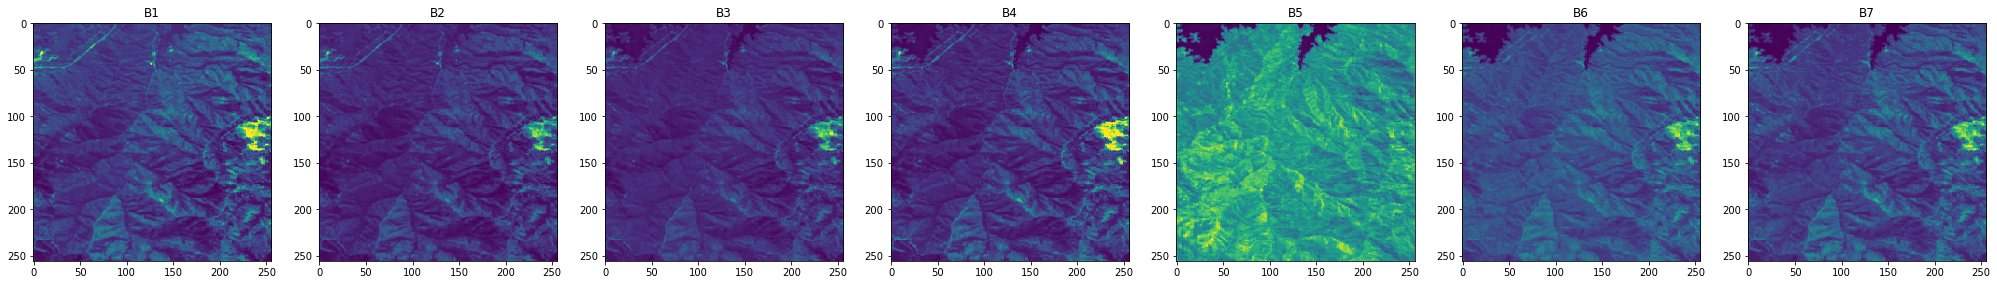

In [33]:
display_channels(input_arr[3,:,:,:], input_arr.shape[3], titles=inBands)

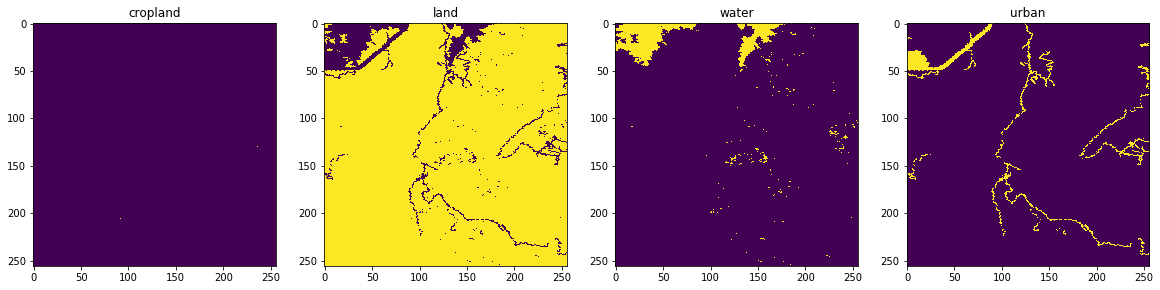

In [34]:
display_channels(output_arr[3,:,:,:], output_arr.shape[3], titles=outBands)

***
## Training the model in AI Platform
### Training code package setup

It's necessary to create a Python package to hold the training code.  Here we're going to get started with that by creating a folder for the package and adding an empty `__init__.py` file.

In [ ]:
ROOT_PATH = 'AI_Platform/cnn_trainer'
PACKAGE_FOLDER = '/trainer'

!rm -r {ROOT_PATH}
!mkdir {ROOT_PATH}
!mkdir {ROOT_PATH+PACKAGE_FOLDER}
!touch {ROOT_PATH+PACKAGE_FOLDER}/__init__.py
!ls -l {ROOT_PATH+PACKAGE_FOLDER}

**Files**

`env.py` file into the folder.

In [ ]:
!cp env.py {ROOT_PATH+PACKAGE_FOLDER}/env.py

**Variables**

These variables need to be stored in a place where other code can access them.  There are a variety of ways of accomplishing that, but here we'll use the `%%writefile` command to write the contents of the code cell to a file called `config.py`.

In [ ]:
%%writefile {ROOT_PATH+PACKAGE_FOLDER}/config.py

from . import env
import tensorflow as tf

# Define your Google Cloud Storage bucket
bucket = env.bucket_name

# Specify names of output locations in Cloud Storage.
dataset_name = 'Landsat8_Cropland'
job_dir = 'gs://' + bucket + '/' + 'cnn-models/'+ dataset_name +'/trainer'
model_dir = job_dir + '/model'
logs_dir = job_dir + '/logs'

# Pre-computed training and eval data.
base_names = ['training_patches', 'eval_patches']
folder = 'cnn-models/'+dataset_name+'/data'

# Specify inputs/outputs to the model
in_bands = ['B1','B2','B3','B4','B5','B6','B7']
out_bands = ['cropland', 'land', 'water', 'urban']

# Specify the size and shape of patches expected by the model.
kernel_size = 256

# Sizes of the training and evaluation datasets.
train_size = 1000*47
eval_size = 1000*12

# Specify model training parameters.
batch_size = 16
epochs = 25
shuffle_size = 2000
learning_rate = 1e-3
optimizer = tf.keras.optimizers.SGD(lr=learning_rate)
loss = 'mse'
metrics = ['accuracy']

**Training/evaluation data**

The following is code to load training/evaluation data.  Write this into `util.py`.

In [ ]:
%%writefile {ROOT_PATH+PACKAGE_FOLDER}/util.py
"""Utilities to download and preprocess the data."""

from . import config
import tensorflow as tf

def parse_function(proto):
    """The parsing function.
    Read a serialized example into the structure defined by features_dict.
    Args:
      example_proto: a serialized Example.
    Returns: 
      A dictionary of tensors, keyed by feature name.
    """
    
    # Define your tfrecord 
    features = config.in_bands + config.out_bands
    
    # Specify the size and shape of patches expected by the model.
    kernel_shape = [config.kernel_size, config.kernel_size]
    columns = [
      tf.io.FixedLenFeature(shape=kernel_shape, dtype=tf.float32) for k in features
    ]
    features_dict = dict(zip(features, columns))
    
    # Load one example
    parsed_features = tf.io.parse_single_example(proto, features_dict)

    # Convert a dictionary of tensors to a tuple of (inputs, outputs)
    inputs_list = [parsed_features.get(key) for key in features]
    stacked = tf.stack(inputs_list, axis=0)
    
    # Convert the tensors into a stack in HWC shape
    stacked = tf.transpose(stacked, [1, 2, 0])
    
    return stacked[:,:,:len(config.in_bands)], stacked[:,:,len(config.in_bands):]

def get_dataset(glob):
    """Get the preprocessed training dataset
    Returns: 
    A tf.data.Dataset of training data.
    """
    glob = tf.compat.v1.io.gfile.glob(glob)
    
    dataset = tf.data.TFRecordDataset(glob, compression_type='GZIP')
    dataset = dataset.map(parse_function, num_parallel_calls=5)
    
    return dataset


def get_training_dataset():
    """Get the preprocessed training dataset
    Returns: 
    A tf.data.Dataset of training data.
    """
    glob = 'gs://' + config.bucket + '/' + config.folder + '/' + config.base_names[0] + '*'
    dataset = get_dataset(glob)
    dataset = dataset.shuffle(config.shuffle_size).batch(config.batch_size).repeat()
    return dataset

def get_evaluation_dataset():
    """Get the preprocessed evaluation dataset
    Returns: 
      A tf.data.Dataset of evaluation data.
    """
    glob = 'gs://' + config.bucket + '/' + config.folder + '/' + config.base_names[1] + '*'
    dataset = get_dataset(glob)
    dataset = dataset.batch(1).repeat()
    return dataset

Verify that `util.py` is functioning as intended.

In [ ]:
from AI_Platform.cnn_trainer.trainer import config
from AI_Platform.cnn_trainer.trainer import util

training_dataset = util.get_training_dataset()
training_dataset

**Model**

Here we use the Keras implementation of the SegNet or DeepVel models. We write this into `model.py`.

**`DeepVel`**

In [ ]:
%%writefile {ROOT_PATH+PACKAGE_FOLDER}/model.py

"""DeepVel model.

DeepVel: Deep learning for the estimation of horizontal
velocities at the solar surface
https://www.aanda.org/articles/aa/pdf/2017/08/aa30783-17.pdf

"""

from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Add
from tensorflow.python.keras.layers.core import Layer, Activation, Reshape
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D


def residual(inputs, filter_size, kernel):
    x = Conv2D(filter_size, kernel, padding='same', kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filter_size, kernel, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Add()([x, inputs])

    return x

def create_keras_model(inputShape, nClasses):
    """
    DeepVel model
    ----------
    inputShape : tuple
        Tuple with the dimensions of the input data (ny, nx, nBands). 
    nClasses : int
            Number of classes.
    """
        
    filter_size = 64
    kernel = (3, 3)        
    n_residual_layers = 5  

            
    inputs = Input(shape=inputShape, name='image')

    conv = Conv2D(filter_size, kernel, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)

    x = residual(conv, filter_size, kernel)
    for i in range(n_residual_layers):
        x = residual(x, filter_size, kernel)

    x = Conv2D(filter_size, kernel, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Add()([x, conv])

    outputs = Conv2D(nClasses, (1, 1), activation='softmax', padding='same', kernel_initializer='he_normal', name= 'output')(x)

    model = Model(inputs=inputs, outputs=outputs, name='deepvel')
        
    return model

**`SegNet`**

In [ ]:
%%writefile {ROOT_PATH+PACKAGE_FOLDER}/model.py

"""SegNet model.

SegNet: A Deep Convolutional Encoder-Decoder Architecture for Image Segmentation
https://arxiv.org/pdf/1511.00561.pdf

"""

from tensorflow.python.keras import Model
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.layers.core import Layer, Activation, Reshape, Permute
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D

def create_keras_model(inputShape, nClasses):
    """
    SegNet model
    ----------
    inputShape : tuple
        Tuple with the dimensions of the input data (ny, nx, nBands). 
    nClasses : int
         Number of classes.
    """

    filter_size = 64
    kernel = (3, 3)        
    pad = (1, 1)
    pool_size = (2, 2)
        

    inputs = Input(shape=inputShape, name= 'image')
        
    # Encoder
    x = Conv2D(64, kernel, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=pool_size)(x)
            
    x = Conv2D(128, kernel, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=pool_size)(x)
            
    x = Conv2D(256, kernel, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=pool_size)(x)
            
    x = Conv2D(512, kernel, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
            
            
    # Decoder
    x = Conv2D(512, kernel, padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D(size=pool_size)(x)
            
    x = Conv2D(256, kernel, padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D(size=pool_size)(x)
            
    x = Conv2D(128, kernel, padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D(size=pool_size)(x)
            
    x = Conv2D(64, kernel, padding='same')(x)
    x = BatchNormalization()(x)
            
    x = Conv2D(nClasses, (1, 1), padding='valid')(x)
    
    outputs = Activation('softmax', name= 'output')(x)
        
    model = Model(inputs=inputs, outputs=outputs, name='segnet')
        
    return model

Verify that `model.py` is functioning as intended.

In [ ]:
from AI_Platform.cnn_trainer.trainer import config
from AI_Platform.cnn_trainer.trainer import model

model = model.create_keras_model(inputShape = (None, None, len(config.in_bands)), nClasses = len(config.out_bands))
print(model.summary())

**Training task**

The following will create `task.py`, which will get the training and evaluation data, train the model and save it when it's done in a Cloud Storage bucket.

In [ ]:
%%writefile {ROOT_PATH+PACKAGE_FOLDER}/task.py
"""Trains a Keras model"""

from . import config
from . import model
from . import util

import os
import time
import tensorflow as tf


def train_and_evaluate():
    """Trains and evaluates the Keras model.

    Uses the Keras model defined in model.py and trains on data loaded and
    preprocessed in util.py. Saves the trained model in TensorFlow SavedModel
    format to the path defined in part by the --job-dir argument.
    """

    # Create the Keras Model
    keras_model = model.create_keras_model(inputShape = (None, None, len(config.in_bands)), nClasses = len(config.out_bands))

    # Compile Keras model
    keras_model.compile(loss=config.loss, optimizer=config.optimizer, metrics=config.metrics)


    # Pass a tfrecord
    training_dataset = util.get_training_dataset()
    evaluation_dataset = util.get_evaluation_dataset()

    # Setup TensorBoard callback.
    tensorboard_cb = tf.keras.callbacks.TensorBoard(config.logs_dir)

    # Train model
    keras_model.fit(
        x=training_dataset,
        steps_per_epoch=int(config.train_size / config.batch_size),
        epochs=config.epochs,
        validation_data=evaluation_dataset,
        validation_steps=int(config.eval_size / config.batch_size),
        verbose=1,
        callbacks=[tensorboard_cb])

    tf.contrib.saved_model.save_keras_model(keras_model, os.path.join(config.model_dir, str(int(time.time()))))

if __name__ == '__main__':
    tf.logging.set_verbosity('INFO')
    train_and_evaluate()

**Using GPUs**

AI Platform lets you run any TensorFlow training application on a GPU-enabled machine. Learn more about [using GPUs for training models in the cloud](https://cloud.google.com/ml-engine/docs/tensorflow/using-gpus#submit-job).
We define a `config.yaml` file that describes the GPU options we want. 

In [ ]:
%%writefile {ROOT_PATH}/config.yaml

trainingInput:
    scaleTier: CUSTOM
    # A single NVIDIA Tesla V100 GPU
    masterType: large_model_v100

### Submit the package to AI Platform for training

In [ ]:
import time

# INSERT YOUR PROJECT HERE!
PROJECT_ID = env.project_id
REGION = "europe-west4"

JOB_NAME = 'job_v' + str(int(time.time()))
TRAINER_PACKAGE_PATH = 'AI_Platform/cnn_trainer/trainer'
MAIN_TRAINER_MODULE = 'trainer.task'

**Set up your GCP project**

Enter your project ID in the cell below. Then run the cell to make sure the Cloud SDK uses the right project for all the commands in this notebook.

In [ ]:
! gcloud config set project $PROJECT_ID

**Authenticate your GCP account**

Enter the path to your service account key as the
`GOOGLE_APPLICATION_CREDENTIALS` variable in the cell below and run the cell.

In [ ]:
%env GOOGLE_APPLICATION_CREDENTIALS 'privatekey.json'

**Submit a training job to AI Platform**

In [ ]:
!gcloud ai-platform jobs submit training {JOB_NAME} \
    --job-dir {config.job_dir} \
    --package-path {TRAINER_PACKAGE_PATH} \
    --module-name {MAIN_TRAINER_MODULE} \
    --region {REGION} \
    --config {ROOT_PATH}/config.yaml \
    --runtime-version 1.14 \
    --python-version 3.5 

**Monitor the training job**

In [ ]:
desc = !gcloud ai-platform jobs describe {JOB_NAME} --project {PROJECT_ID}
state = desc.grep('state:')[0].split(':')[1].strip()
print(state)

***
## Prepare the model for making predictions in Earth Engine

Before we can use the model in Earth Engine, it needs to be hosted by AI Platform.  But before we can host the model on AI Platform we need to *EEify* (a new word!) it.  The EEification process merely appends some extra operations to the input and outputs of the model in order to accomdate the interchange format between pixels from Earth Engine (float32) and inputs to AI Platform (base64).  (See [this doc](https://cloud.google.com/ml-engine/docs/online-predict#binary_data_in_prediction_input) for details.)  

**`earthengine model prepare`**

The EEification process is handled for you using the Earth Engine command `earthengine model prepare`.  To use that command, we need to specify the input and output model directories and the name of the input and output nodes in the TensorFlow computation graph.  We can do all that programmatically:

In [ ]:
inBands = ['B1','B2','B3','B4','B5','B6','B7']
outBands = ['cropland', 'land', 'water', 'urban']

# Specify names of input locations in Cloud Storage.
dataset_name = 'Landsat8_Cropland'
job_dir = 'gs://' + env.bucket_name + '/' + 'cnn-models/' + dataset_name + '/trainer'
model_dir = job_dir + '/model'
PROJECT_ID = env.project_id

In [ ]:
# Pick the directory with the latest timestamp, in case you've trained multiple times
exported_model_dirs = ! gsutil ls {model_dir}
saved_model_path = exported_model_dirs[-1]

folder_name = saved_model_path.split('/')[-2]

In [ ]:
from tensorflow.python.tools import saved_model_utils

meta_graph_def = saved_model_utils.get_meta_graph_def(saved_model_path, 'serve')
inputs = meta_graph_def.signature_def['serving_default'].inputs
outputs = meta_graph_def.signature_def['serving_default'].outputs

# Just get the first thing(s) from the serving signature def.  i.e. this
# model only has a single input and a single output.
input_name = None
for k,v in inputs.items():
    input_name = v.name
    break

output_name = None
for k,v in outputs.items():
    output_name = v.name
    break

# Make a dictionary that maps Earth Engine outputs and inputs to 
# AI Platform inputs and outputs, respectively.
import json
input_dict = "'" + json.dumps({input_name: "array"}) + "'"
output_dict = "'" + json.dumps({output_name: "prediction"}) + "'"

# Put the EEified model next to the trained model directory.
EEIFIED_DIR = job_dir + '/eeified/' + folder_name

# You need to set the project before using the model prepare command.
!earthengine set_project {PROJECT_ID}
!earthengine model prepare --source_dir {saved_model_path} --dest_dir {EEIFIED_DIR} --input {input_dict} --output {output_dict}

**Deployed the model to AI Platform**

Before it's possible to get predictions from the trained and EEified model, it needs to be deployed on AI Platform.  The first step is to create the model.  The second step is to create a version.  See [this guide](https://cloud.google.com/ml-engine/docs/tensorflow/deploying-models) for details.  Note that models and versions can be monitored from the [AI Platform models page](http://console.cloud.google.com/ai-platform/models) of the Cloud Console. 

To ensure that the model is ready for predictions without having to warm up nodes, you can use a configuration yaml file to set the scaling type of this version to autoScaling, and, set a minimum number of nodes for the version. This will ensure there are always nodes on stand-by, however, you will be charged as long as they are running. For this example, we'll set the minNodes to 10. That means that at a minimum, 10 nodes are always up and running and waiting for predictions. The number of nodes will also scale up automatically if needed.

In [ ]:
%%writefile config.yaml
autoScaling:
    minNodes: 10

In [ ]:
import time
REGION = "us-west1"
MODEL_NAME = 'segnet_'+dataset_name
VERSION_NAME = 'v' + folder_name
print('Creating version: ' + VERSION_NAME)

!gcloud ai-platform models create {MODEL_NAME} 
!gcloud ai-platform versions create {VERSION_NAME} \
  --model {MODEL_NAME} \
  --origin {EEIFIED_DIR} \
  --runtime-version=1.14 \
  --framework "TENSORFLOW" \
  --python-version=3.5

***
## Predict in Earth Engine
**Variables**

In [ ]:
inCollection = 'Landsat8_SR'
inBands = ['B1','B2','B3','B4','B5','B6','B7']
outBands = ['cropland', 'land', 'water', 'urban']
startDate = '2016-01-01'
stopDate = '2016-12-31'
scale = 30 #scale in meters

# Model variables
PROJECT_ID = env.project_id
MODEL_NAME = 'segnet_Landsat8_Cropland'
VERSION_NAME = VERSION_NAME

# polygon where we want to display de predictions
geometry = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              -6.2862396240234375,
              36.84226271217676
            ],
            [
              -6.13037109375,
              36.84226271217676
            ],
            [
              -6.13037109375,
              36.94550173495345
            ],
            [
              -6.2862396240234375,
              36.94550173495345
            ],
            [
              -6.2862396240234375,
              36.84226271217676
            ]
          ]
        ]
      }
    }
  ]
}

**`ee.Model.fromAiPlatformPredictor`**

There is now a trained model, prepared for serving to Earth Engine, hosted and versioned on AI Platform.  
We can now connect Earth Engine directly to the trained model for inference.  You do that with the `ee.Model.fromAiPlatformPredictor` command.
For this command to work, we need to know a lot about the model.  To connect to the model, you need to know the name and version.

**Inputs**

You need to be able to recreate the imagery on which it was trained in order to perform inference.  Specifically, you need to create an array-valued input from the scaled data and use that for input.  (Recall that the new input node is named `array`, which is convenient because the array image has one band, named `array` by default.)  The inputs will be provided as 144x144 patches (`inputTileSize`), at 30-meter resolution (`proj`), but 8 pixels will be thrown out (`inputOverlapSize`) to minimize boundary effects.

In [ ]:
import requests

payload =   {
    "collection": inCollection,
    "start": startDate,
    "end": stopDate,
    "scale": scale
}

url = f'https://us-central1-skydipper-196010.cloudfunctions.net/pre_processing'

headers = {'Content-Type': 'application/json'}

output_pre_processing = requests.post(url, data=json.dumps(payload), headers=headers)
output_pre_processing.json()

image = ee.deserializer.fromJSON(output.json()['composite'])

Select bands and convert them into float

In [ ]:
image = image.select(inBands).float()
image.getInfo()

**Outputs**

The output (which you also need to know).

In [ ]:
# Load the trained model and use it for prediction.
model = ee.Model.fromAiPlatformPredictor(
    projectName = PROJECT_ID,
    modelName = MODEL_NAME,
    version = VERSION_NAME,
    inputTileSize = [144, 144],
    inputOverlapSize = [8, 8],
    proj = ee.Projection('EPSG:4326').atScale(scale),
    fixInputProj = True,
    outputBands = {'prediction': {
        'type': ee.PixelType.float(),
        'dimensions': 1,
      }                  
    }
)
predictions = model.predictImage(image.toArray()).arrayFlatten([outBands])
predictions.getInfo()

Clip the prediction area with the polygon

In [ ]:
# Clip the prediction area with the polygon
polygon = ee.Geometry.Polygon(geometry.get('features')[0].get('geometry').get('coordinates'))
predictions = predictions.clip(polygon)

# Get centroid
centroid = polygon.centroid().getInfo().get('coordinates')[::-1]

**Display**

Use folium to visualize the input imagery and the predictions.

In [ ]:
# Define the URL format used for Earth Engine generated map tiles.
EE_TILES = 'https://earthengine.googleapis.com/map/{mapid}/{{z}}/{{x}}/{{y}}?token={token}'

mapid = image.getMapId({'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 1})
map = folium.Map(location=centroid, zoom_start=12)
folium.TileLayer(
    tiles=EE_TILES.format(**mapid),
    attr='Google Earth Engine',
    overlay=True,
    name='median composite',
  ).add_to(map)

for band in outBands:
    mapid = predictions.getMapId({'bands': [band], 'min': 0, 'max': 1})
    
    folium.TileLayer(
        tiles=EE_TILES.format(**mapid),
        attr='Google Earth Engine',
        overlay=True,
        name=band,
      ).add_to(map)

map.add_child(folium.LayerControl())
map

***
## Predict in AI Platform
**Variables**

In [ ]:
inCollection = 'Landsat8_SR'
inBands = ['B1','B2','B3','B4','B5','B6','B7']
outBands = ['cropland', 'land', 'water', 'urban']
startDate = '2016-01-01'
stopDate = '2016-12-31'
scale = 30 #scale in meters

# Model variables
PROJECT_ID = env.project_id
MODEL_NAME = 'segnet_Landsat8_Cropland'
VERSION_NAME = VERSION_NAME

In [ ]:
# Specify names of input locations in Cloud Storage.
dataset_name = 'Landsat8_Cropland'
job_dir = 'gs://' + bucket + '/' + 'cnn-models/' + dataset_name + '/trainer'
model_dir = job_dir + '/model' 

exported_model_dirs = ! gsutil ls {model_dir}

# Pick the directory with the latest timestamp, in case you've trained multiple times
saved_model_path = exported_model_dirs[-1]

In [ ]:
import time

MODEL_NAME = 'segnet_Landsat8_Cropland'
VERSION_NAME = VERSION_NAME
print('Creating version: ' + VERSION_NAME)

!gcloud ai-platform models create {MODEL_NAME} 

# Create model version based on that SavedModel directory
! gcloud ai-platform versions create {VERSION_NAME} \
  --model {MODEL_NAME} \
  --runtime-version 1.13 \
  --python-version 3.5 \
  --framework tensorflow \
  --origin {saved_model_path}

In [ ]:
datasetName = 'Landsat8_Cropland'
baseNames = ['training_patches', 'eval_patches']
inBands = ['B1','B2','B3','B4','B5','B6','B7']
outBands = ['cropland', 'land', 'water', 'urban']
        
folder = 'cnn-models/'+datasetName+'/data'
kernel_size = 256
buffer_size = 100
batch_size = 4

glob = 'gs://' + env.bucket_name + '/' + folder + '/' + baseNames[0] + '_g0'+ '*'
dataset = get_dataset(glob, inBands, outBands, kernel_size, buffer_size, batch_size)
dataset

In [ ]:
display_channels(input_arr[2,:80,:80,:], input_arr.shape[3], titles=inBands)

**Formatting input data for online prediction**

In [ ]:
data = input_arr[2,:80,:80,:]
data = np.around(data,2).tolist()
instance = {"image" : data}

**Requesting predictions**

In [ ]:
from google.oauth2 import service_account
import googleapiclient

def predict_json(project, model, instances, privatekey_path, version=None):
    """Send json data to a deployed model for prediction.

    Args:
        project (str): project where the AI Platform Model is deployed.
        model (str): model name.
        instances ([Mapping[str: Any]]): Keys should be the names of Tensors
            your deployed model expects as inputs. Values should be datatypes
            convertible to Tensors, or (potentially nested) lists of datatypes
            convertible to tensors.
        version: str, version of the model to target.
    Returns:
        Mapping[str: any]: dictionary of prediction results defined by the
            model.
    """    
    # To authenticate set the GOOGLE_APPLICATION_CREDENTIALS
    credentials = service_account.Credentials.from_service_account_file(privatekey_path)
    
    # Create the AI Platform service object.
    service = googleapiclient.discovery.build('ml', 'v1', credentials=credentials)
    name = 'projects/{}/models/{}'.format(project, model)

    if version is not None:
        name += '/versions/{}'.format(version)

    response = service.projects().predict(
        name=name,
        body={'instances': instances}
    ).execute()

    if 'error' in response:
        raise RuntimeError(response['error'])

    return response['predictions']

**Submit the online prediction request**

In [ ]:
privatekey_path = 'privatekey.json'
response = predict_json(project=PROJECT_ID, model=MODEL_NAME, instances=instance, privatekey_path=privatekey_path, version=VERSION_NAME)

In [ ]:
output = np.array(response[0].get('output'))
output.shape
display_channels(output, output.shape[2], titles=['cropland', 'land', 'water', 'urban'])

***
## Data post-processing

**Variables**